In [2]:
import gym
from gym import Env
from gym.spaces import Discrete,Box,Dict,Tuple,MultiBinary,MultiDiscrete

import numpy as np
import random
import os

from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy


In [2]:
Discrete(3)

Discrete(3)

Running simmulation... 
The average wait time is 130 minutes and 108 seconds.



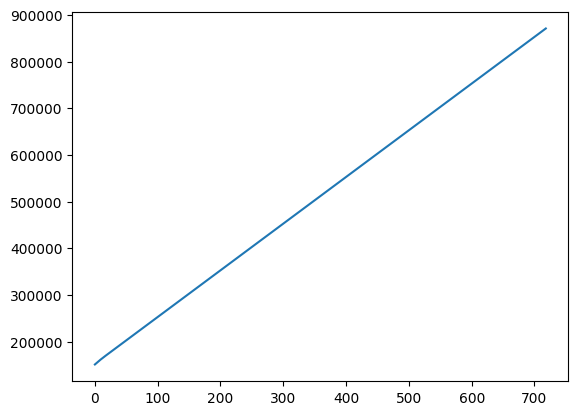

In [5]:
import simpy
import random
import statistics
import numpy as np
import matplotlib.pyplot as plt

battery_trend = []
wait_times = []
time_stamp = []
#Create an class that mimics an charging station
class Charging_station():
    #Init method for the charging station class
    def __init__(self,env,num_charging_stations):
        self.env = env
        self.charge_station = simpy.Resource(env,num_charging_stations)
        self.battery_amount =150000
        self.amount = 2
        self.battery_drained = False
        self.solar_power = 20

    #This method controls the solar panel 
    def solar_panel(self):
        while True:
            yield self.env.timeout(0.016)
            #This method controls the solar panel
            self.battery_amount += self.solar_power

    def trend_battery(self):
        time = 0
        while True:
            #Trend the battery status every minute
            yield self.env.timeout(1)
            battery_trend.append(self.battery_amount)  
            time_stamp.append(time)
            time +=1


    #This method simmulates the charging of a vechicle
    def charge_vechicle(self, vehicle):
        # Set a random time for 
        if self.battery_amount >1:
            self.amount = 2
        else:
            if self.battery_drained == False:
                print("Battery Drained")
                self.battery_drained = True 
            self.amount = 1
        
        self.battery_amount -= 1
        yield self.env.timeout(0.016)        



class Truck():
    #Init the truck class
    def __init__(self,charge_left,number):
        self.charge = charge_left
        self.number = number

    def charge_truck(self,env,truck,charging_station):
        #Get the starting time
        begin_time = env.now
        #Charge the truck
        with charging_station.charge_station.request() as request:
            #Wait for an free charging station
            yield request
            #Start the charging
            while self.charge < 7200:
                yield env.process(charging_station.charge_vechicle(truck))
                self.charge += charging_station.amount
        #Determine the total time a truckdriver is needing for a charge
        wait_times.append(env.now -begin_time) #Deze moet wel aan blijven!!!!!!!



#This function runs the charging station
def run_station(env,num_chargers):
    truck = []
    number = 1
    #Create the simmulation enviroment
         
    #Set 1 car in the waiting line
    truck.append(Truck(50,1))
    #Add the solat panel to the enviroment\
    env.process(charge_station.solar_panel())
    env.process(truck[1 -1].charge_truck(env,truck,charge_station))
    env.process(charge_station.trend_battery())
    while True:
        yield env.timeout(5)
        truck.append(Truck(50,1))
        number += 1
        truck.append(Truck(50,number))
        env.process(truck[number -1].charge_truck(env,truck,charge_station))



def get_average_wait_time(arrival_times):
    average_wait = statistics.mean(wait_times)
    # Pretty print the results
    minutes, frac_minutes = divmod(average_wait, 2)
    seconds = frac_minutes * 60
    return round(minutes), round(seconds)

#The main method for the systme
def truck_sim(env): 
    #Setup the main system
    random.seed(30)
    #Run the simmulation
    
    env.process(run_station(env,5))

    #Run the simmulation for 1 day
    env.run(until= 720)
    #View the results
    mins, secs = get_average_wait_time(wait_times)
    print("Running simmulation...", 
          f"\nThe average wait time is {mins} minutes and {secs} seconds.")
    
    print()

env_sim = simpy.Environment()
charge_station = Charging_station(env_sim,4 )

truck_sim(env_sim)

y = np.array(battery_trend)
x = np.array(time_stamp)
slope, intercept = np.polyfit(x, y, 1)
plt.plot(x, y)



In [13]:
#Create a truck enviroment that the model is going to perform in
class TruckEnv(Env):
    def __init__(self):
        self.action_space = Box(low = 0, high = 0.00006, shape = (1,))
        self.observation_space = Box(low = 0, high = 15000, shape =(1,))
        self.state = 15000

    def step(self,action):
        #Apply the adjustment on the state
        charge_station.solar_power = action
        #Run the simmulation
        env_sim = simpy.Environment()
        truck_sim(env_sim)
        #Check if the battery is near zero
        if charge_station.battery_amount < 1000 and charge_station.battery_amount >= 0:
            reward = 1
        else:
            reward = - 1

        info = {}
        return charge_station.battery_amount, reward, True, info
    
    def render(self):
        pass

    def reset(self):
        pass

In [15]:
env = TruckEnv()

episodes = 5
for episode in range(1,episodes+1):
    state = env.reset()
    done = False
    score = 0

    while not done:
        env.render()
        action = env.action_space.sample()
        n_state, reward, done, info = env.step(action)
        score += reward
    print('Episode:{} Score:{}'.format(episode, score))
env.close()

Running simmulation... 
The average wait time is 130 minutes and 108 seconds.

Episode:1 Score:-1
Running simmulation... 
The average wait time is 130 minutes and 108 seconds.

Episode:2 Score:-1
Running simmulation... 
The average wait time is 130 minutes and 108 seconds.

Episode:3 Score:-1
Running simmulation... 
The average wait time is 130 minutes and 108 seconds.

Episode:4 Score:-1
Running simmulation... 
The average wait time is 130 minutes and 108 seconds.

Episode:5 Score:-1
